# Wav2Vec2 Model for Deepfake Audio Detection

## Summary of Key Processing Steps in Wav2Vec2

1. Directly processes raw audio using convolutional layers in the feature encoder.
2. Utilizes a Transformer to capture temporal relationships across the audio sequence.
3. Fine-tunes easily for classification tasks by adding a lightweight classification head.
4. Pre-trained on vast unlabeled audio data, enabling it to perform well with limited labeled data for classification.

   

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp /content/drive/MyDrive/Datasets/dataset.zip /content/

In [9]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: selected_train_audio/spoof/LA_T_2850612.flac  
  inflating: selected_train_audio/spoof/LA_T_1282219.flac  
  inflating: selected_train_audio/spoof/LA_T_4512688.flac  
  inflating: selected_train_audio/spoof/LA_T_2307693.flac  
  inflating: selected_train_audio/spoof/LA_T_3897361.flac  
  inflating: selected_train_audio/spoof/LA_T_1930732.flac  
  inflating: selected_train_audio/spoof/LA_T_3070376.flac  
  inflating: selected_train_audio/spoof/LA_T_1365409.flac  
  inflating: selected_train_audio/spoof/LA_T_4091103.flac  
  inflating: selected_train_audio/spoof/LA_T_2599425.flac  
  inflating: selected_train_audio/spoof/LA_T_3891659.flac  
  inflating: selected_train_audio/spoof/LA_T_4238059.flac  
  inflating: selected_train_audio/spoof/LA_T_4761800.flac  
  inflating: selected_train_audio/spoof/LA_T_1674369.flac  
  inflating: selected_train_audio/spoof/LA_T_3314176.flac  
  inflating: selected_train_audio/spoof/LA_T_1784

In [10]:
# Standard library imports
import os
import random
from tqdm import tqdm

# Third-party imports
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import Wav2Vec2Processor, WhisperFeatureExtractor
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data Visualization

> In the realm of deepfake audio detection, various audio features are instrumental in distinguishing between authentic and synthetic recordings. Among these, spectrograms, Mel spectrograms, and chroma features are particularly noteworthy.

### Spectograms
* Spectrograms provide a visual representation of an audio signal's frequency spectrum over time, capturing both temporal and spectral information. This dual representation is advantageous for detecting anomalies indicative of deepfake audio. For instance, certain synthesis methods may introduce artifacts or inconsistencies in the frequency domain, which become apparent when analyzing spectrograms. By examining these visual patterns, researchers can identify irregularities that suggest audio manipulation.
ARXIV

## Mel Spectograms
* Mel spectrograms are a variant of spectrograms that map frequencies onto the Mel scale, aligning more closely with human auditory perception. This perceptually motivated scaling emphasizes frequencies to which the human ear is more sensitive, thereby enhancing the detection of subtle artifacts introduced by deepfake generation techniques. Studies have demonstrated that Mel spectrograms, when used as input features for convolutional neural networks, improve the accuracy of deepfake audio detection systems.
ICTACT JOURNALS

## Chroma Features
* Chroma features capture the energy distribution across the twelve distinct pitch classes of the musical octave, effectively summarizing harmonic content. In the context of deepfake detection, chroma features are valuable for identifying inconsistencies in the harmonic structure of audio signals. Synthetic audio may exhibit unnatural harmonic patterns or deviations in pitch class distributions, which chroma analysis can reveal. Incorporating chroma features into detection frameworks has been shown to enhance the robustness of classifiers against various types of audio forgeries.
IEEE XPLORE

> Collectively, these features—spectrograms, Mel spectrograms, and chroma features—serve as critical tools in the detection of deepfake audio. By providing comprehensive insights into the spectral, perceptual, and harmonic characteristics of audio signals, they enable more effective identification of synthetic content.

In [11]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

def visualize_audio_features(audio_file):
    """
    Visualizes different audio representations: waveform, spectrogram, Mel spectrogram, and chroma feature.

    Args:
        audio_file (str): Path to a specific audio file (.flac or any other format supported by torchaudio).
    """
    # Load the audio file
    audio, sample_rate = torchaudio.load(audio_file)

    # Ensure audio is in mono for consistent visualization
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0)

    # Normalize audio for better visualization
    audio = audio / torch.max(torch.abs(audio))
    waveform_audio = audio.squeeze().numpy()

    # Display the original waveform
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(waveform_audio, color='red')
    plt.title("Waveform")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Compute and display the spectrogram
    spectrogram = torchaudio.transforms.Spectrogram()(audio)
    plt.subplot(2, 2, 2)
    plt.imshow(spectrogram.log2().squeeze().detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")

    # Compute and display the Mel Spectrogram
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(audio)
    plt.subplot(2, 2, 3)
    plt.imshow(mel_spectrogram.log2().squeeze().detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")

    # Compute and display the Chroma feature using librosa
    try:
        import librosa
        import librosa.display
        # Convert audio tensor to numpy array for librosa processing
        audio_np = audio.numpy().flatten()
        mel_spectrogram_librosa = librosa.feature.melspectrogram(y=audio_np, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(S=mel_spectrogram_librosa, sr=sample_rate)
        plt.subplot(2, 2, 4)
        librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.colorbar()
        plt.title("Chroma Feature")
        plt.xlabel("Time")
        plt.ylabel("Pitch Class")
    except ImportError:
        print("Librosa is required for Chroma visualization. Please install it with `pip install librosa`.")

    plt.tight_layout()
    plt.show()

    # Play the audio
    print("Playing Audio:")
    display(Audio(audio.numpy(), rate=sample_rate))

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


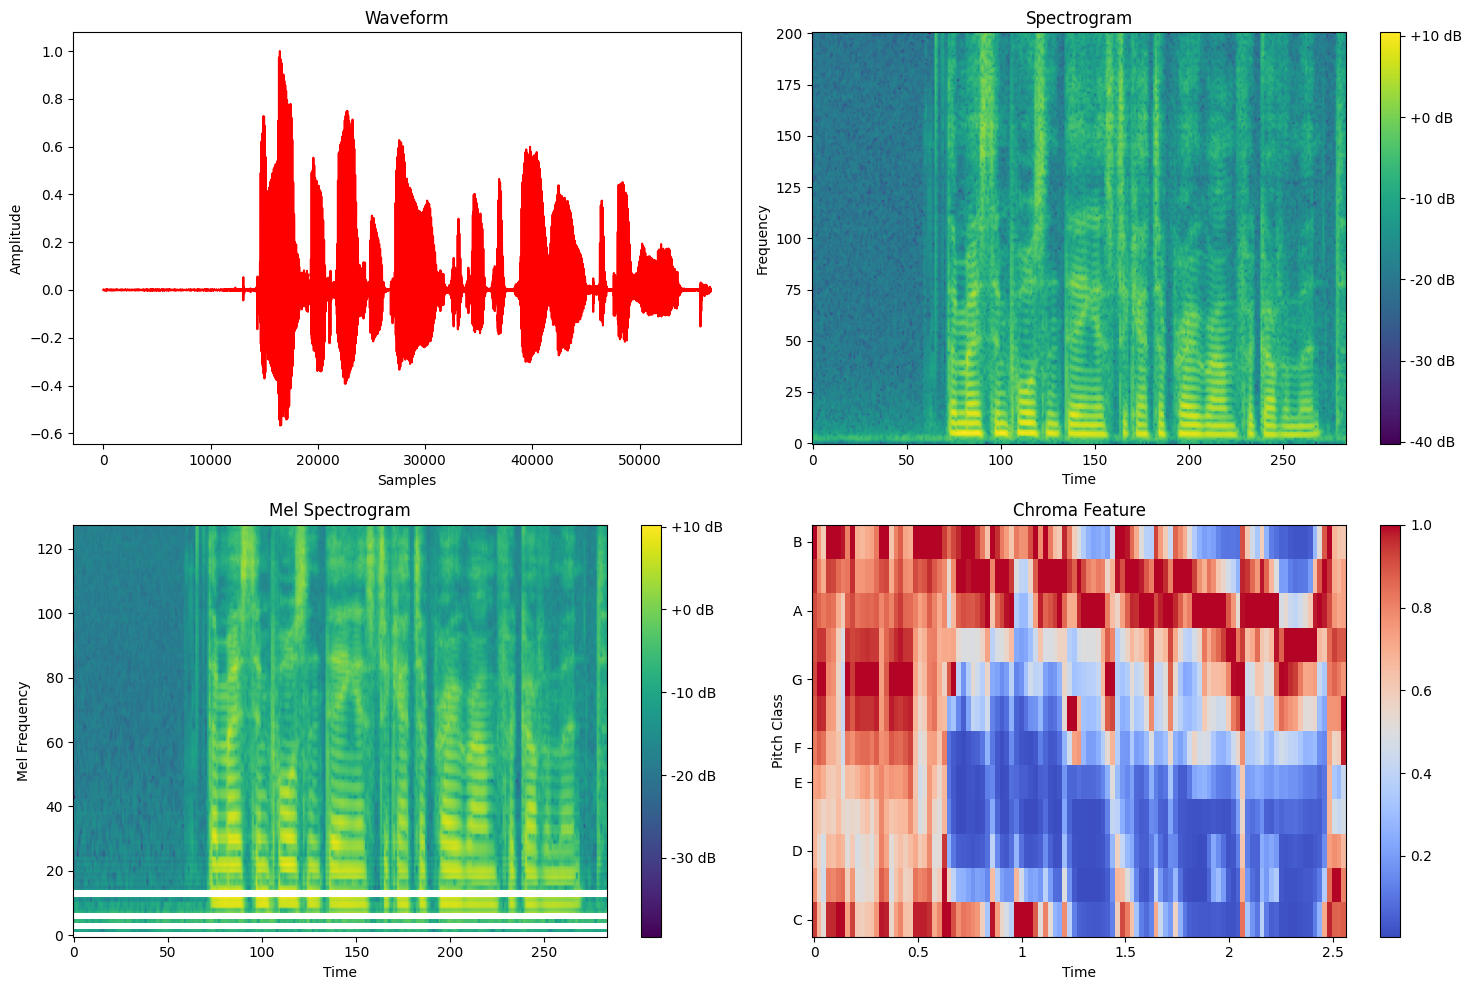

Playing Audio:


In [12]:
visualize_audio_features(audio_file="/content/selected_train_audio/bonafide/LA_T_1013597.flac")

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


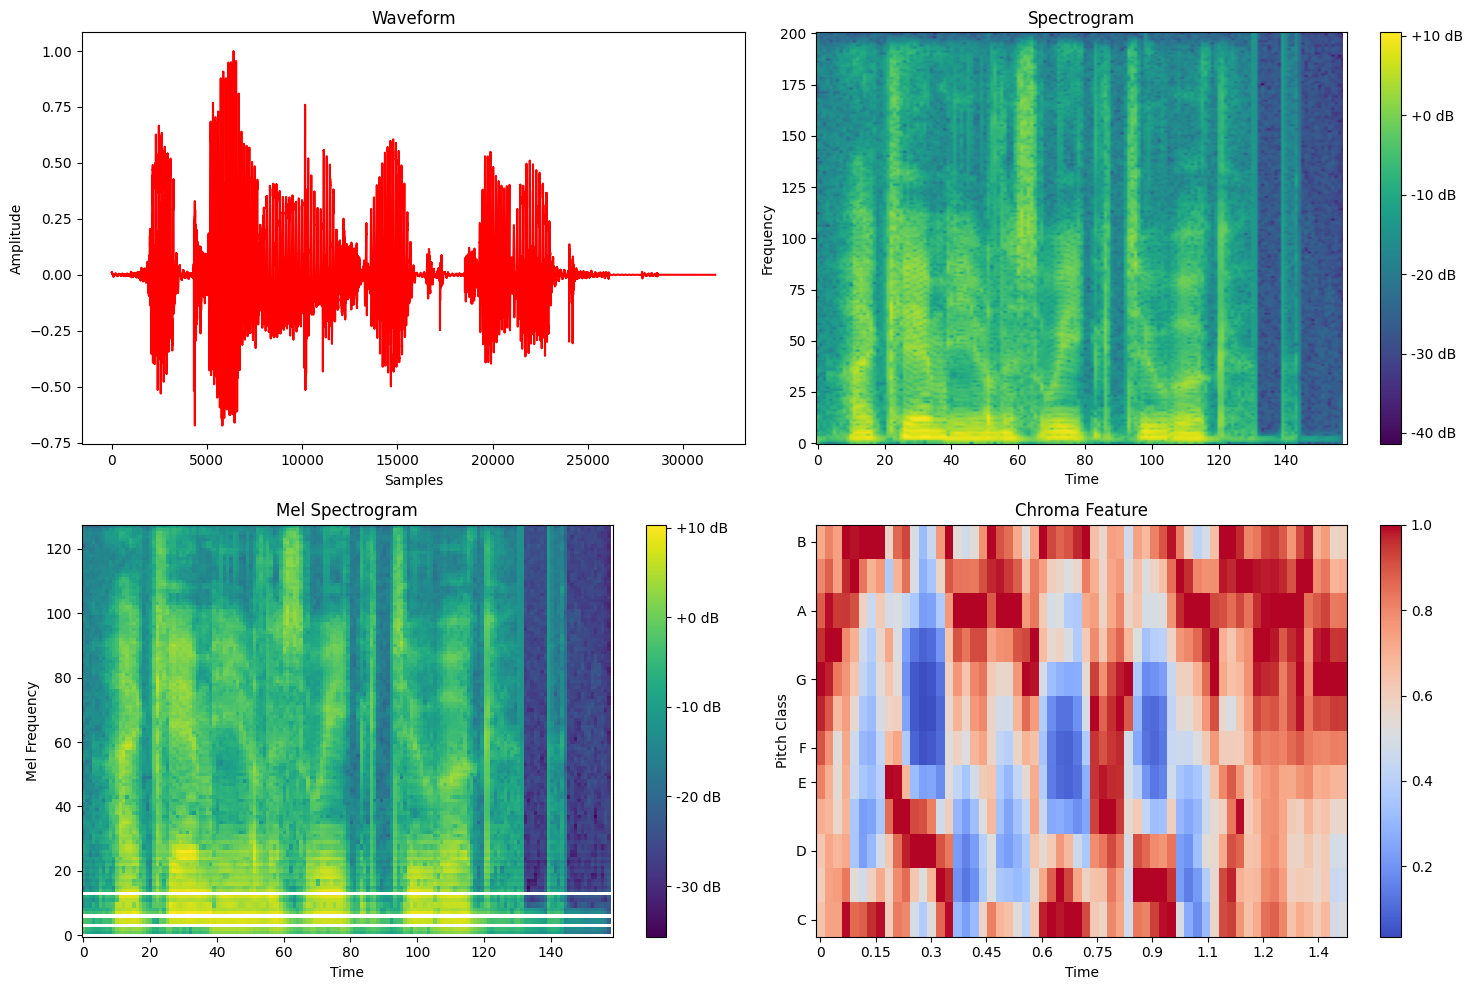

Playing Audio:


In [13]:
visualize_audio_features(audio_file="/content/selected_train_audio/spoof/LA_T_1001871.flac")

In [14]:
#Dataset Making Process

import os
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset

class ASVSpoof(Dataset):
    def __init__(self, base_dir, csv_file, target_length=64000):
        """
        Initializes the ASVSpoof dataset for WavLM.

        Args:
            base_dir (str): Base directory containing the 'bonafide' and 'spoof' subdirectories,
                            where audio files are organized by label.
            csv_file (str): Path to a CSV file with two columns, 'Filename' and 'Label', indicating
                            the filename of each audio file and its label ('bonafide' or 'spoof').
            target_length (int): Desired length (in samples) of each audio clip after padding or trimming.
                                 For a 16 kHz sampling rate, 64000 samples represent 4 seconds.
        """
        self.base_dir = base_dir
        self.target_length = target_length

        # Load the CSV file as a DataFrame and map labels to integer values
        self.data = pd.read_csv(csv_file)
        self.label_mapping = {"bonafide": 0, "spoof": 1}
        self.data['Label'] = self.data['Label'].map(self.label_mapping)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the filename and label at the given index
        file_name = self.data.loc[idx, 'Filename']
        label = self.data.loc[idx, 'Label']

        # Determine the subdirectory ('bonafide' or 'spoof') based on the label
        subdir = "bonafide" if label == 0 else "spoof"

        # Construct the full path to the audio file
        file_path = os.path.join(self.base_dir, subdir, f"{file_name}.flac")

        # Load the audio file and convert it to mono if it has multiple channels
        audio, sample_rate = torchaudio.load(file_path)
        if audio.shape[0] > 1:
            audio = audio.mean(dim=0, keepdim=True)  # Convert to mono by averaging channels

        # Trim or pad the audio to the target length
        audio = self.trim_or_pad_audio(audio.squeeze())

        # Return raw audio and label; processing will happen in collate_fn
        return {
            "audio": audio,
            "label": torch.tensor(label, dtype=torch.long)
        }

    def trim_or_pad_audio(self, audio):
        """
        Pads or trims the audio tensor to match the target length.

        Args:
            audio (torch.Tensor): 1D tensor of audio samples.

        Returns:
            torch.Tensor: Audio tensor with length equal to target_length.
        """
        if len(audio) > self.target_length:
            return audio[:self.target_length]
        elif len(audio) < self.target_length:
            padding = self.target_length - len(audio)
            return torch.nn.functional.pad(audio, (0, padding))
        return audio

########################### We moved processing to Collate function to make it Faster ##########################################

In [15]:
from transformers import Wav2Vec2FeatureExtractor

# Initialize the Wav2Vec2FeatureExtractor for WavLM
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")

def collate_fn(batch):
    # Extract audio and labels from the batch
    audios = [item["audio"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch])

    # Use the feature extractor to process the audio
    inputs = feature_extractor(
        audios,
        sampling_rate=16000,
        return_tensors="pt",
        padding="longest"  # or "max_length" with a set max length, if needed
    )

    # Return the processed inputs and labels
    return {
        "input_values": inputs.input_values.squeeze(0),  # Mel-spectrogram feature sequences
        "attention_mask": inputs.attention_mask.squeeze(0),  # Attention mask for padding
        "labels": labels.squeeze(0)
    }


def create_dataloader(base_dir, csv_file, batch_size=4, shuffle=True):
    """
    Creates an optimized DataLoader for the ASVSpoof dataset.

    Args:
        base_dir (str): Path to base directory containing audio files in 'bonafide' and 'spoof' subdirectories.
        csv_file (str): Path to CSV file with filenames and labels.
        processor (WhisperFeatureExtractor): Processor for audio data.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle data.
        num_workers (int): Number of subprocesses to use for data loading.
        pin_memory (bool): Whether to use pinned memory for faster data transfer to GPU.

    Returns:
        DataLoader: Configured DataLoader for the dataset.
    """
    dataset = ASVSpoof(base_dir, csv_file, target_length = 64_000)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [48]:
# Configuration settings for the ASVSpoof project

# BASE_DIRS = {
#     "train": "../dataset/dataset/selected_train_audio/",
#     "val": "../dataset/dataset/selected_val_audio/",
#     "test": "../dataset/dataset/selected_test_audio/"
# }

BASE_DIRS = {
    "train": "/content/selected_train_audio/",
    "val": "/content/selected_val_audio/",
    "test": "/content/selected_test_audio/"
}

# CSV_FILES = {
#     "train": "../dataset/dataset/train_balanced_dataframe.csv",
#     "val": "../dataset/dataset/val_dataframe.csv",
#     "test": "../dataset/dataset/test_dataframe.csv"
# }

CSV_FILES = {
    "train": "/content/train_balanced_dataframe.csv",
    "val": "/content/val_dataframe.csv",
    "test": "/content/test_dataframe.csv"
}

BASE_MODEL = "facebook/wav2vec2-base"
NUM_LABELS = 1

# Set batch size
BATCH_SIZE = 48

## Model Definition Wav2Vec2 For Deepfake Detection

In [49]:
import torch
from torch import nn
from transformers import Wav2Vec2Model

# Define Wav2Vec2Classifier for audio classification (encoder-only approach)
class Wav2Vec2Classifier(nn.Module):
    """
    A custom classifier for audio classification using the Wav2Vec2 encoder,
    fine-tuned for binary classification (e.g., real or fake audio).
    """
    def __init__(self, model_name: str, num_labels: int):
        super(Wav2Vec2Classifier, self).__init__()
        # Load Wav2Vec2 model without a classification head
        self.wav2vec2_model = Wav2Vec2Model.from_pretrained(model_name)

        # Freeze Wav2Vec2 model parameters to prevent updates during training
        for param in self.wav2vec2_model.parameters():
            param.requires_grad = False

        # Get hidden size of the Wav2Vec2 encoder
        hidden_size = self.wav2vec2_model.config.hidden_size

        # Classification head
        self.classifier = nn.Linear(hidden_size, num_labels)


    def forward(self, input_features):
        """
        Forward pass through the Wav2Vec2 encoder and classification head.

        Args:
            input_features (torch.Tensor): Preprocessed audio features tensor.

        Returns:
            torch.Tensor: Logits for each class.
        """
        # Pass inputs through Wav2Vec2 encoder to get hidden states
        outputs = self.wav2vec2_model(input_features)
        last_hidden_state = outputs.last_hidden_state  # shape (batch_size, seq_len, hidden_size)

        # Pool the outputs (e.g., take the mean over the sequence length)
        pooled_output = last_hidden_state.mean(dim=1)  # shape (batch_size, hidden_size)

        # Pass through the classifier
        logits = self.classifier(pooled_output)

        return logits

    def predict(self, input_features: torch.Tensor) -> int:
        """
        Makes a prediction based on the preprocessed audio input.

        Args:
            input_features (torch.Tensor): Preprocessed audio features tensor.

        Returns:
            int: Predicted class (0 or 1).
        """
        logits = self.forward(input_features)

        return logits

In [50]:
# Defining dataloader and model for training purpose

model = Wav2Vec2Classifier(model_name = BASE_MODEL, num_labels = NUM_LABELS)

train_loader = create_dataloader(BASE_DIRS["train"], CSV_FILES["train"], batch_size=BATCH_SIZE)
val_loader = create_dataloader(BASE_DIRS["val"], CSV_FILES["val"], batch_size=BATCH_SIZE)
test_loader = create_dataloader(BASE_DIRS["test"], CSV_FILES["test"], batch_size=BATCH_SIZE)


# Example of accessing data from train_loader
for batch in train_loader:
    print(batch["input_values"].shape)
    print(batch["attention_mask"].shape)
    print(batch["labels"].shape)
    break  # Print the shape of one batch and exit


# Example of accessing data from val_loader
for batch in val_loader:
    print(batch["input_values"].shape)
    print(batch["attention_mask"].shape)
    print(batch["labels"].shape)
    break  # Print the shape of one batch and exit


# Example of accessing data from test_loader
for batch in test_loader:
    print(batch["input_values"].shape)
    print(batch["attention_mask"].shape)
    print(batch["labels"].shape)
    break  # Print the shape of one batch and exit

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


torch.Size([48, 64000])
torch.Size([48])
torch.Size([48])
torch.Size([48, 64000])
torch.Size([48])
torch.Size([48])
torch.Size([48, 64000])
torch.Size([48])
torch.Size([48])


In [32]:
!pip install torchinfo

In [51]:
# Calculating forward and backward pass memory
# Total memory used by model parameters (in bytes)
from torchinfo import summary

# Assuming `model` is your PyTorch model
batch_size = 48  # Or the batch size you'd like to simulate
input_shape = (batch_size, 64000)  # Replace `input_shape` with your model's input dimensions

# Print the model summary
summary(model, input_size=input_shape, col_names=["input_size", "output_size", "num_params", "params_percent"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Param %
Wav2Vec2Classifier                                      [48, 64000]               [48, 1]                   --                             --
├─Wav2Vec2Model: 1-1                                    [48, 64000]               [48, 199, 512]            768                         0.00%
│    └─Wav2Vec2FeatureEncoder: 2-1                      [48, 64000]               [48, 512, 199]            --                             --
│    │    └─ModuleList: 3-1                             --                        --                        (4,200,448)                 4.45%
│    └─Wav2Vec2FeatureProjection: 2-2                   [48, 199, 512]            [48, 199, 768]            --                             --
│    │    └─LayerNorm: 3-2                              [48, 199, 512]            [48, 199, 512]            (1,024)                     0.00%
│    │

In [34]:
import wandb

In [53]:
# This code is adapted from Homework 1 and changed to accomododate Wav2Vec2 Training

# Common settings and constants
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
GAMMA = 0.9  # Decay factor for the exponential scheduler
NUM_EPOCHS = 20
ACCUMULATION_STEPS = 1
CHECKPOINT_PATH = "./Wav2Vec2/wav2vec2_checkpoint.pth"
DEVICE = "cuda"
#DEVICE = "cpu"

# Enable cuDNN benchmarking for faster computation on compatible architectures
torch.backends.cudnn.benchmark = True

# Initialize Weights and Biases (wandb) logging
wandb.init(project="audio-classification", name="Wav2Vec2 Deepfake Detection")

model = model.to(DEVICE)

# Define optimizer, scheduler, and loss function
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss function

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

# Lists to keep track of training and validation losses
train_losses = []
val_losses = []

# Function to load checkpoint
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_accuracy = checkpoint['best_val_acc']
        print(f"Loading checkpoints from epoch {start_epoch+1} with best validation accuracy {best_val_accuracy:.4f}")
        return start_epoch, best_val_loss
    else:
        print("No checkpoint found. Starting training from scratch.")
        return 0, float('inf')

# Load checkpoint if available
start_epoch, best_val_loss = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler)

wandb: Currently logged in as: avinash-saxena (avinash-saxena-san-jose-state-university). Use `wandb login --relogin` to force relogin


No checkpoint found. Starting training from scratch.


In [54]:
if  os.path.exists("./Wav2Vec2") == False:
    os.mkdir("./Wav2Vec2")

In [55]:

# Training and Validation function
def train_and_validate(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, start_epoch=0, best_val_acc=0):
    model = model.to(DEVICE)
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        print("Model is running on:", next(model.parameters()).device)

        running_loss = 0.0
        correct = 0
        total = 0

        # Improve DataLoader efficiency
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

        optimizer.zero_grad()  # Reset gradients before each epoch
        for i, batch in enumerate(train_bar):
            inputs = batch["input_values"].to(DEVICE, non_blocking=True)
            attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
            labels = batch["labels"].to(DEVICE, non_blocking=True).float()  # Convert labels to float

            # Mixed precision training with autocast
            with torch.amp.autocast("cuda"):
                # Forward pass
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensuring outputs have shape [batch_size]
                loss = criterion(outputs, labels)
                loss = loss / ACCUMULATION_STEPS  # Scale the loss for accumulation

            # Backward pass
            scaler.scale(loss).backward()

            # Update weights and zero gradients after ACCUMULATION_STEPS iterations

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Track metrics efficiently with vectorized operations
            running_loss += loss.detach() * inputs.size(0) * ACCUMULATION_STEPS
            predicted = (outputs > 0).long()  # Use threshold of 0 for binary classification
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()

        # Calculate training loss and accuracy
        epoch_train_loss = running_loss.item() / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            for batch in val_bar:
                inputs = batch["input_values"].to(DEVICE, non_blocking=True)
                attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
                labels = batch["labels"].to(DEVICE, non_blocking=True).float()  # Convert labels to float

                # Mixed precision training with autocast
                with torch.amp.autocast("cuda"):
                    # Forward pass
                    outputs = model(inputs)
                    outputs = outputs.squeeze()  # Ensuring outputs have shape [batch_size]
                    loss = criterion(outputs, labels)

                # Track validation metrics efficiently
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0).long()  # Use threshold of 0 for binary classification
                val_total += labels.size(0)
                val_correct += (predicted == labels.long()).sum().item()

        # Calculate validation loss and accuracy
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        # Logging to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_train_loss,
            'train_accuracy': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_acc
        })

        # Save model if it has the best validation accuracy
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            model_save_path = f"./Wav2Vec2//wav2vec2_best_val_acc_{best_val_acc:.2f}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc
            }, model_save_path)
            print(f"New best model saved with validation accuracy {best_val_acc:.2f}% at epoch {epoch + 1}")

        # Step the scheduler
        scheduler.step()


# Run training and validation
train_and_validate(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, start_epoch=start_epoch, best_val_acc=0)

# End WandB session if using wandb
wandb.finish()

Model is running on: cuda:0


Epoch 1/20, Train Loss: 0.6075, Train Acc: 80.33%, Val Loss: 0.5441, Val Acc: 77.20%
New best model saved with validation accuracy 77.20% at epoch 1
Model is running on: cuda:0


Epoch 2/20, Train Loss: 0.4926, Train Acc: 88.24%, Val Loss: 0.4546, Val Acc: 84.60%
New best model saved with validation accuracy 84.60% at epoch 2
Model is running on: cuda:0


Epoch 3/20, Train Loss: 0.4322, Train Acc: 88.88%, Val Loss: 0.4687, Val Acc: 78.80%
Model is running on: cuda:0


Epoch 4/20, Train Loss: 0.3978, Train Acc: 89.30%, Val Loss: 0.4296, Val Acc: 81.50%
Model is running on: cuda:0


Epoch 5/20, Train Loss: 0.3765, Train Acc: 90.08%, Val Loss: 0.4082, Val Acc: 82.20%
Model is running on: cuda:0


Epoch 6/20, Train Loss: 0.3567, Train Acc: 90.62%, Val Loss: 0.3823, Val Acc: 84.20%
Model is running on: cuda:0


Epoch 7/20, Train Loss: 0.3415, Train Acc: 90.78%, Val Loss: 0.3769, Val Acc: 84.30%
Model is running on: cuda:0


Epoch 8/20, Train Loss: 0.3308, Train Acc: 91.01%, Val Loss: 0.3811, Val Acc: 83.80%
Model is running on: cuda:0


Epoch 9/20, Train Loss: 0.3209, Train Acc: 91.28%, Val Loss: 0.3711, Val Acc: 84.20%
Model is running on: cuda:0


Epoch 10/20, Train Loss: 0.3140, Train Acc: 91.14%, Val Loss: 0.3657, Val Acc: 84.70%
New best model saved with validation accuracy 84.70% at epoch 10
Model is running on: cuda:0


Epoch 11/20, Train Loss: 0.3075, Train Acc: 91.61%, Val Loss: 0.3590, Val Acc: 85.00%
New best model saved with validation accuracy 85.00% at epoch 11
Model is running on: cuda:0


Epoch 12/20, Train Loss: 0.3005, Train Acc: 91.57%, Val Loss: 0.3346, Val Acc: 86.20%
New best model saved with validation accuracy 86.20% at epoch 12
Model is running on: cuda:0


Epoch 13/20, Train Loss: 0.2938, Train Acc: 91.90%, Val Loss: 0.3451, Val Acc: 85.30%
Model is running on: cuda:0


Epoch 14/20, Train Loss: 0.2914, Train Acc: 92.13%, Val Loss: 0.3419, Val Acc: 85.80%
Model is running on: cuda:0


Epoch 15/20, Train Loss: 0.2890, Train Acc: 92.02%, Val Loss: 0.3359, Val Acc: 85.80%
Model is running on: cuda:0


Epoch 16/20, Train Loss: 0.2879, Train Acc: 91.86%, Val Loss: 0.3384, Val Acc: 85.70%
Model is running on: cuda:0


Epoch 17/20, Train Loss: 0.2834, Train Acc: 91.94%, Val Loss: 0.3339, Val Acc: 85.70%
Model is running on: cuda:0


Epoch 18/20, Train Loss: 0.2849, Train Acc: 92.07%, Val Loss: 0.3371, Val Acc: 85.70%
Model is running on: cuda:0


Epoch 19/20, Train Loss: 0.2794, Train Acc: 92.05%, Val Loss: 0.3326, Val Acc: 85.70%
Model is running on: cuda:0


Epoch 20/20, Train Loss: 0.2764, Train Acc: 92.15%, Val Loss: 0.3293, Val Acc: 86.00%


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▆▆▆▇▇▇▇▇▇██████████
train_loss,█▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▇▂▄▅▆▇▆▆▇▇█▇███████
val_loss,█▅▆▄▄▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁
epoch,20
train_accuracy,92.15116
train_loss,0.27641
val_accuracy,86
val_loss,0.32934


## Evaluating the Model on Test Dataset

In [56]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the Wav2Vec2Classifier model
model = Wav2Vec2Classifier(model_name=BASE_MODEL, num_labels=NUM_LABELS)  # Adjust model_name and num_labels as needed
model = model.to(device)


# Set the model to evaluation mode
model.eval()


# Load the checkpoint (replace with the actual checkpoint path if needed)
checkpoint_path = "/content/Wav2Vec2/wav2vec2_best_val_acc_86.20.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

print("loading saved model")
start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer, scheduler)

# Set the model to evaluation mode
model.eval()

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing", leave=False)
        for batch in test_bar:
            # Extract input features and labels from the batch dictionary
            input_features = batch["input_values"].to(device)  # Corrected to match your dictionary key
            labels = batch["labels"]

            # Forward pass
            logits = model(input_features).squeeze()  # Remove extra dimensions if present

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)

            # Classify based on a 0.5 threshold
            predicted = (probs > 0.5).long()

            # Store predictions and labels for metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print and log the metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Optional: return metrics for further analysis
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Run the evaluation
test_metrics = evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
<ipython-input-56-96ce36104914>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they

loading saved model
Loading checkpoint from /content/Wav2Vec2/wav2vec2_best_val_acc_86.20.pth


<ipython-input-53-82b0613c557d>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loading checkpoints from epoch 13 with best validation accuracy 86.2000


Test Accuracy: 0.8125
Precision: 0.9756
Recall: 0.6410
F1 Score: 0.7737


In [62]:
import pandas as pd
metrics_df = pd.DataFrame(test_metrics, index=[0])
metrics_df.to_csv("/content/Wav2Vec2/test_metrics.csv", index=False)